Strategies for deploying TL saved models

This notebook requires several extra libraries and servers than are provided
in the `requirements.txt` to run. First, you will need jupyter.

```
pip install jupyter
```

Docker is used to run tensorflow serving. ocker will require installing and
configuring your system. You can get started here: https://www.docker.com/.

`graphviz` and `pydot` is used for keras graph plotting.

```
pip install pydot graphviz
```

Graphviz probably needs some libraries on your system (at least I did).
You can install them with the following, if you are in a Debian based
system.

```
apt install graphviz
```

In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import requests
import json
import os

2025-06-17 13:19:17.479063: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load our model, produced with `train.py`.

In [2]:
model = keras.models.load_model('model.keras')

For fun, let's plot the graph.

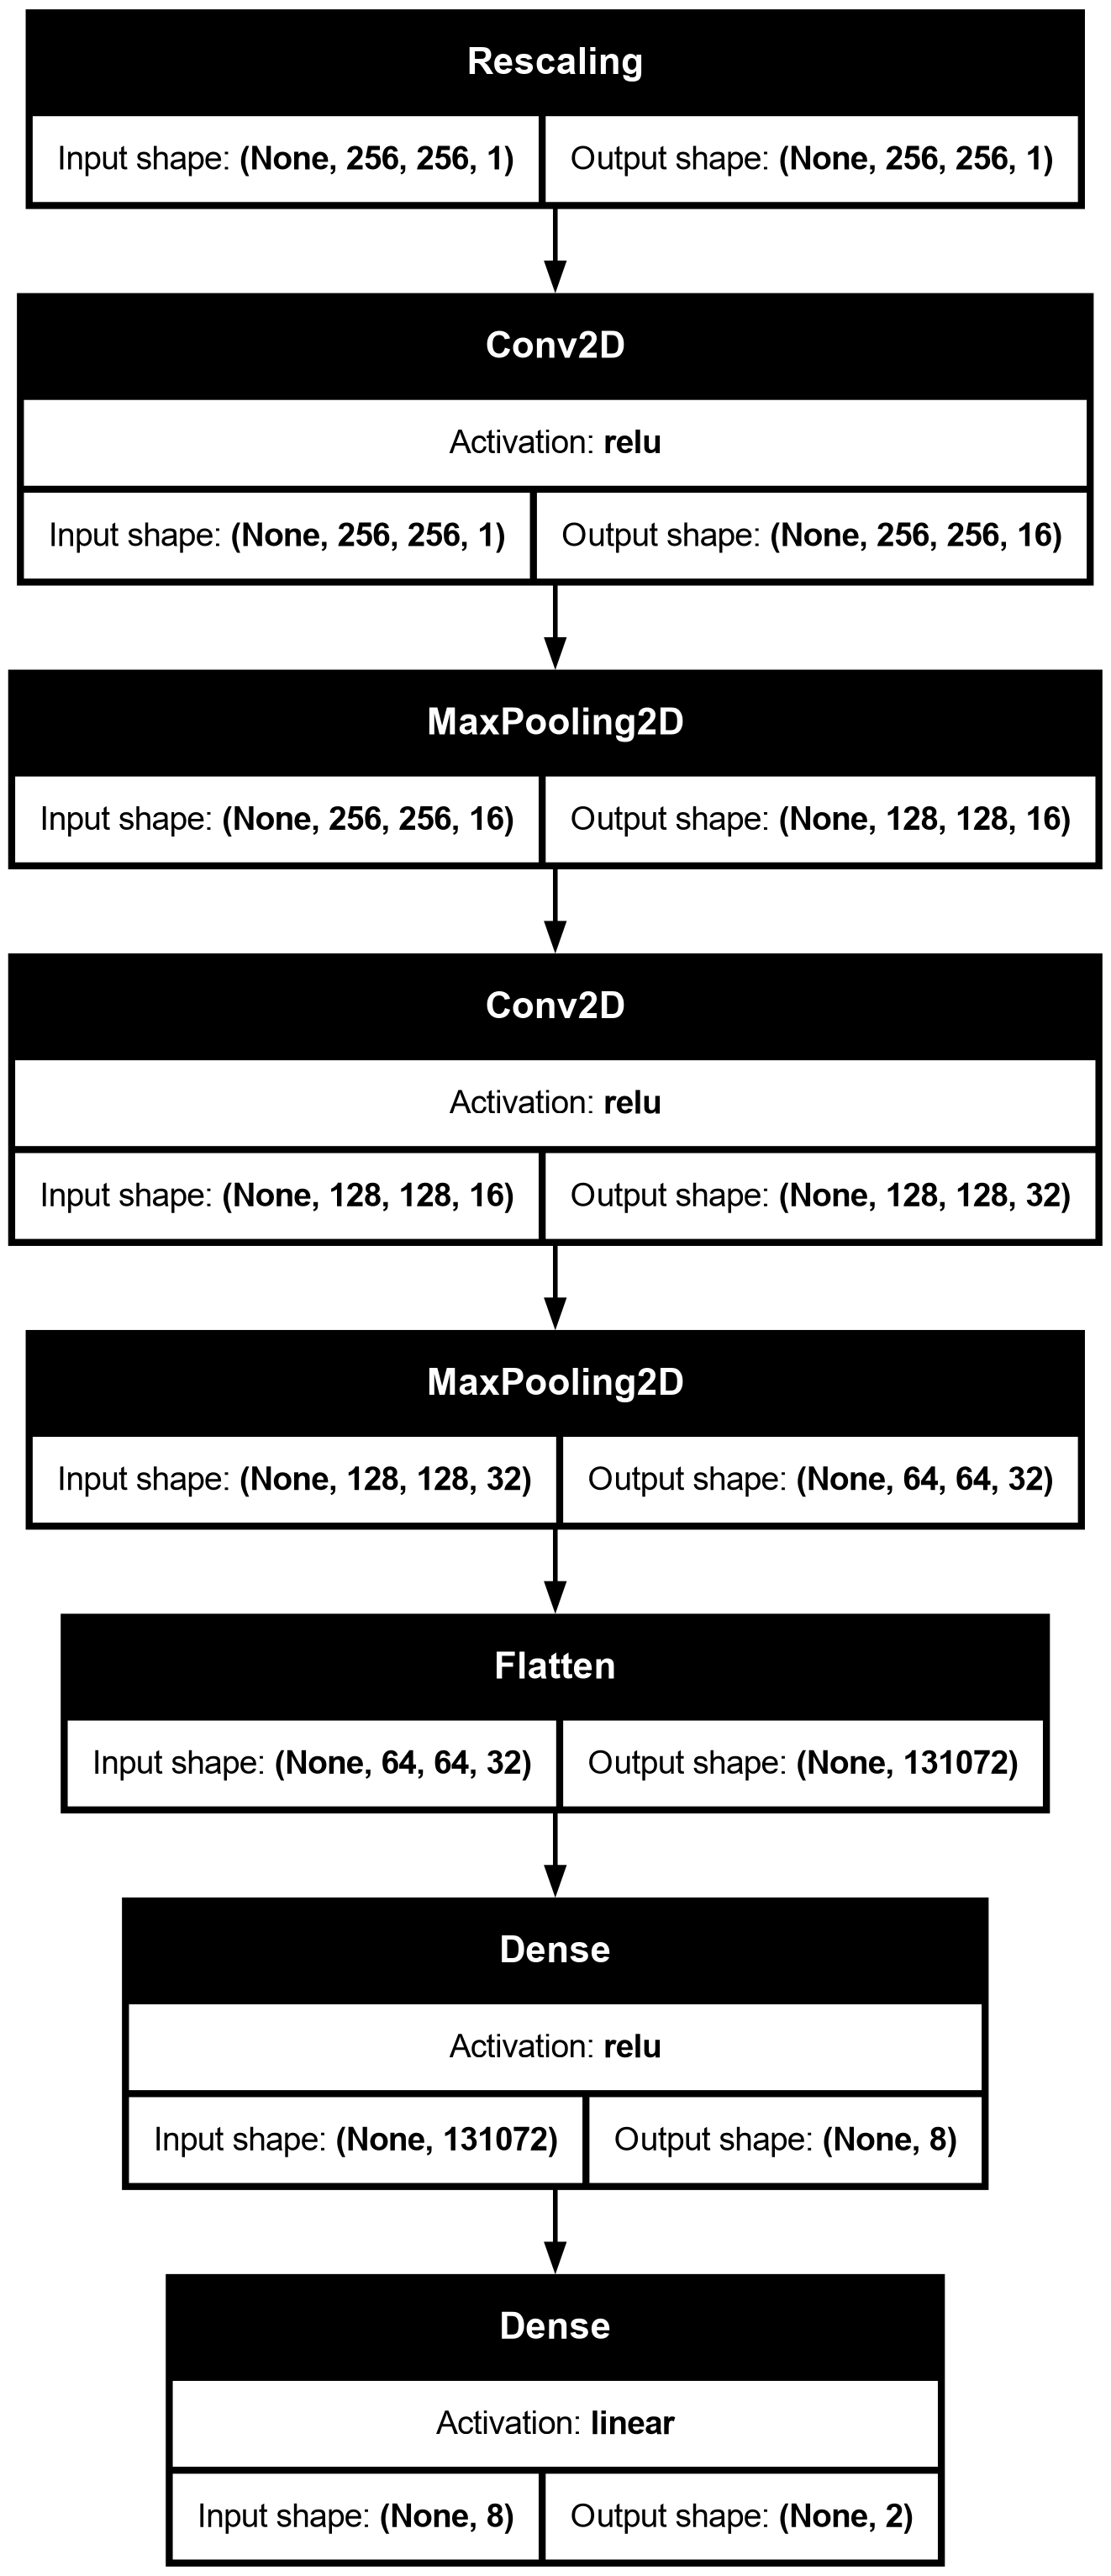

In [3]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_activations=True
)

Export this as a "Saved Model"

In [4]:
model.export(
    'saved_models/model/1'
)

INFO:tensorflow:Assets written to: saved_models/model/1/assets


INFO:tensorflow:Assets written to: saved_models/model/1/assets


Saved artifact at 'saved_models/model/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  140581012643216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140581012646480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140581012646096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140581012646672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140581012648592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140581012649360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140581012648400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140581012648016: TensorSpec(shape=(), dtype=tf.resource, name=None)


Let's serve this with Docker and Tensorflow serving

In [5]:
! docker pull tensorflow/serving
! docker run --rm -d -v "$PWD/saved_models/model:/models/model" -eMODEL_NAME="model" -t -p8501:8501  tensorflow/serving

Using default tag: latest
latest: Pulling from tensorflow/serving
Digest: sha256:289a8ca157c7873098c49484ef6de53940f7443140a66a1cec5613181be18a53
Status: Image is up to date for tensorflow/serving:latest
docker.io/tensorflow/serving:latest
49efc1491fae0f9fd461c0cad44bc2842da4338228a2eceb7908527a652b8d9d
docker: Error response from daemon: failed to set up container networking: driver failed programming external connectivity on endpoint kind_kowalevski (d4a7c9be1d4131fc73962ecdd8d8cb0884b250a94f4d10e237ad2005bb5c2495): Bind for 0.0.0.0:8501 failed: port is already allocated

Run 'docker run --help' for more information


# Ways to interact

First let's grab some data

In [6]:
img = keras.utils.load_img(
    'data/train/open/open_001.jpg',
    color_mode="grayscale",
    target_size=(256, 256)
)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

Run the loaded model (from the Keras file)

In [7]:
model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


array([[-4.114398,  5.785376]], dtype=float32)

Load the export data and server directly

In [8]:
exported_model = tf.saved_model.load('saved_models/model/1')
preds = exported_model.serve(img_array)
print(preds)

tf.Tensor([[-4.114398  5.785376]], shape=(1, 2), dtype=float32)


Using the Docker REST API get the predictions

In [9]:
url = 'http://localhost:8501/v1/models/model:predict'
data = json.dumps({'instances': np.array(img_array).tolist()})
res = requests.post(url, data=data)
print(res.json())

{'predictions': [[-4.114398, 5.78537607]]}


Same, but let's use curl

In [10]:
with open('data.json', 'w') as fp:
    json.dump({'instances': np.array(img_array).tolist()}, fp)
!curl http://localhost:8501/v1/models/model:predict -X POST --data @data.json

{
    "predictions": [[-4.114398, 5.78537607]
    ]
}

Export to "Frozen Graph". This is needed for some APIs. Used
only as an example of the complexities of the various formats.

In [11]:
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

In [12]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
frozen_func = convert_variables_to_constants_v2(full_model)

I0000 00:00:1750159165.051052 2580919 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1750159165.051240 2580919 single_machine.cc:374] Starting new session


In [13]:
# Save frozen graph to disk
path = 'frozen_graph'
basename = 'model'
try:
    os.mkdir(path)
except:
    ...
tf.io.write_graph(
    graph_or_graph_def=frozen_func.graph,
    logdir=path,
    name=f'{basename}.pb',
    as_text=False
)
tf.io.write_graph(
    graph_or_graph_def=frozen_func.graph,
    logdir=path,
    name=f"{basename}.pbtxt",
    as_text=True
)

'frozen_graph/model.pbtxt'

In [14]:
tf.io.write_graph(
    graph_or_graph_def=frozen_func.graph,
    logdir=path,
    name='model',
    as_text=False
)

'frozen_graph/model'